In [58]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from ipywidgets import interactive
import pickle

from scipy.optimize import minimize
from sklearn.metrics import r2_score

# Кривые DEF rate

### Выгружаем модель из ДЗ 6 

In [2]:
df_scores = pd.read_csv(
    'data_scores_and_features.csv',
    encoding="cp1251",
    decimal=','
)
df_scores.head()

,user_id,pd,x_score,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
0,5269,0.039098,0.127199,0.0,0.0,0.0,0.0,1,0.2109592074752989,-7.11111111111111,-57.0,-1.0,-1.0,0.0,-5.834056199159457,0.0,-1.0,0.0
1,157747,0.002988,0.624327,0.0,0.0,0.0,0.0,1,0.20014105588804962,190.714285714286,5.0,3545000.0,-1.0,39646.0,-7.996643776092405,0.0,170.0,0.0
2,112119,0.063419,0.166025,0.90666134822497,0.7777377903065918,0.0,0.0,1,0.8872644089367733,19.0,16.0,-1.0,-1.0,9087.0,-4.420416105665769,0.0,21.0,1.0
3,131663,0.053852,0.097733,1.0036176031824962,0.381490744881551,1.0,1.0,1,0.3718952285895618,138.5,12.0,-1.0,-1.0,1262802.0,-6.395523281487215,0.0,60.0,2.0
4,122778,0.046282,0.458680,0.9003344778922336,0.3479209050537932,0.0,0.0,0,0.3665211217308951,8.2,3.0,-1.0,-1.0,10801.0,-6.920207775647638,0.0,16.0,2.0


In [3]:
df_scores.isna().any()

user_id                    False
pd                         False
x_score                    False
max_util                    True
avg_util                    True
credits_2y                  True
credits_4y                  True
bad_history_credits_flg    False
other_util                  True
avg_term                    True
min_term                    True
avg_limit_mortgage          True
min_limit_mfo               True
close_balance_amt           True
soc_dem_score               True
max_delq_cnt                True
avg_active_time             True
last_credit_time_years      True
dtype: bool

In [4]:
df_scores[df_scores['max_util'].isna()]

,user_id,pd,x_score,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
32506,109960,0.059484,0.156461,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68471,131144,0.033228,0.156461,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93755,143142,0.032949,0.156461,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Имеются объекты с NaN по большинству признаков, включая max_util - их удаление может привести к отсутствию NaNов во многих столбцах

In [5]:
df_scores.drop(df_scores[df_scores['max_util'].isna()].index, axis=0, inplace=True)
df_scores.isna().any()

user_id                    False
pd                         False
x_score                    False
max_util                   False
avg_util                   False
credits_2y                 False
credits_4y                 False
bad_history_credits_flg    False
other_util                 False
avg_term                    True
min_term                    True
avg_limit_mortgage         False
min_limit_mfo              False
close_balance_amt          False
soc_dem_score              False
max_delq_cnt               False
avg_active_time             True
last_credit_time_years     False
dtype: bool

Из ДЗ 7 возьмём значения для заполнения признаков

In [6]:
df_scores['avg_term'].fillna(99.00401397628372, inplace=True)
df_scores['avg_active_time'].fillna(141.75884339517657, inplace=True)
df_scores['avg_term'].fillna(-12.83607724362954, inplace=True)

Найдём "наши" PD

In [7]:
grad_boost = pickle.load(open('from_6_dz_with_love.pickle', 'rb'))
good_features = [\
    'max_util', 
    'avg_util',
    'credits_2y',
    'credits_4y',
    'other_util',
    'avg_limit_mortgage',
    'min_limit_mfo', 
    'close_balance_amt',
    'soc_dem_score',
    'avg_active_time',
    'last_credit_time_years'
]

X_predict = df_scores[good_features]
df_scores['my_pd'] = grad_boost.predict_proba(np.array(X_predict))[:,1]

In [8]:
df_scores2 = df_scores[['user_id', 'pd', 'my_pd', 'x_score']]
df_scores2

,user_id,pd,my_pd,x_score
0,5269,0.039098,0.035258,0.127199
1,157747,0.002988,0.019009,0.624327
2,112119,0.063419,0.067109,0.166025
3,131663,0.053852,0.146778,0.097733
4,122778,0.046282,0.052027,0.458680
...,...,...,...,...
104815,39195,0.025842,0.063378,0.361921
104816,113647,0.085268,0.126490,0.196731
104817,158552,0.022367,0.044079,0.222133
104818,35628,0.051484,0.075548,0.247079


#### Выгружаем данные с винтажами

In [9]:
df1_read = pd.read_csv('data_vintages1.csv')
df2_read = pd.read_csv('data_vintages2.csv')

C:\Users\user\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
df1_read.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336.0,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
1,35907.0,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0
2,45228.0,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0
3,39035.0,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
4,130780.0,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0


Изменим тип данных user_id

In [16]:
df1_read.dropna(inplace=True)
df1_read['user_id'] = df1_read['user_id'].apply(lambda x: int(x))
df1_read['user_id']

0          127336
1           35907
2           45228
3           39035
4          130780
            ...  
1269339     66641
1269340    116651
1269341    132750
1269342      8252
1269343     67818
Name: user_id, Length: 1269343, dtype: int64

In [20]:
df2_read.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,2558,6,2019-02-01,2019-01-01,0,0,0,1,0,0,0,1.0
1,128342,2,2019-08-01,2019-07-01,0,0,0,1,0,0,0,1.0
2,177443,22,2019-11-01,2019-10-01,1,0,0,0,1,0,0,0.0
3,189513,12,2020-02-01,2020-01-01,0,0,0,1,0,0,0,1.0
4,142249,8,2019-09-01,2019-07-01,1,0,0,0,1,0,0,0.0


In [21]:
df2_read.dropna(inplace=True)
print(pd.unique(df2_read['statement_num']))
df2_read['statement_num'] = df2_read['statement_num'].apply(lambda x: int(x))
print(pd.unique(df2_read['statement_num']))

[ 6  2 22 12  8  1  5 10  9 19  4  3 24 11 20 13 15 17 23 18 16 14 21  7]
[ 6  2 22 12  8  1  5 10  9 19  4  3 24 11 20 13 15 17 23 18 16 14 21  7]


In [22]:
df = pd.concat([df1_read, df2_read], ignore_index=True)
df

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2538699,64006,19,2019-05-01,2019-04-01,1,0,0,0,0,0.0,1.0,1.0
2538700,138666,21,2019-09-01,2019-07-01,1,0,0,0,0,0.0,0.0,1.0
2538701,120568,1,2019-08-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
2538702,191861,6,2020-01-01,2020-01-01,0,0,0,1,0,0.0,0.0,1.0


### Разбивка на бакеты по PD и X_score

In [23]:
df_scores2 = df_scores2.sort_values(['my_pd'], ignore_index=True)
df_scores2['my_pd_bucket'] = np.minimum(df_scores2.index // (df_scores2.shape[0]//3),2)
print(df_scores2.groupby(['my_pd_bucket'])['my_pd'].mean())

df_scores2 = df_scores2.sort_values(['x_score'], ignore_index=True)
df_scores2['x_bucket'] = np.minimum(df_scores2.index // (df_scores2.shape[0]//3),2)
print(df_scores2.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores2[['user_id', 'my_pd_bucket', 'x_bucket', 'my_pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

my_pd_bucket
0    0.025826
1    0.050441
2    0.103418
Name: my_pd, dtype: float64
x_bucket
0    0.133271
1    0.220842
2    0.379455
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,my_pd_bucket,x_bucket,my_pd,x_score
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,2.0,2.0,0.074753,0.469410
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.058043,0.157215
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0,1.0,2.0,0.059475,0.469583
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,0.0,1.0,0.033255,0.210896
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0,1.0,1.0,0.046993,0.269492


In [24]:
df[['user_id', 'statement_num', 'my_pd_bucket', 'x_bucket', 'my_pd', 'x_score']].to_csv('my_data_scores.csv')

### Винтажи кривой def ratio

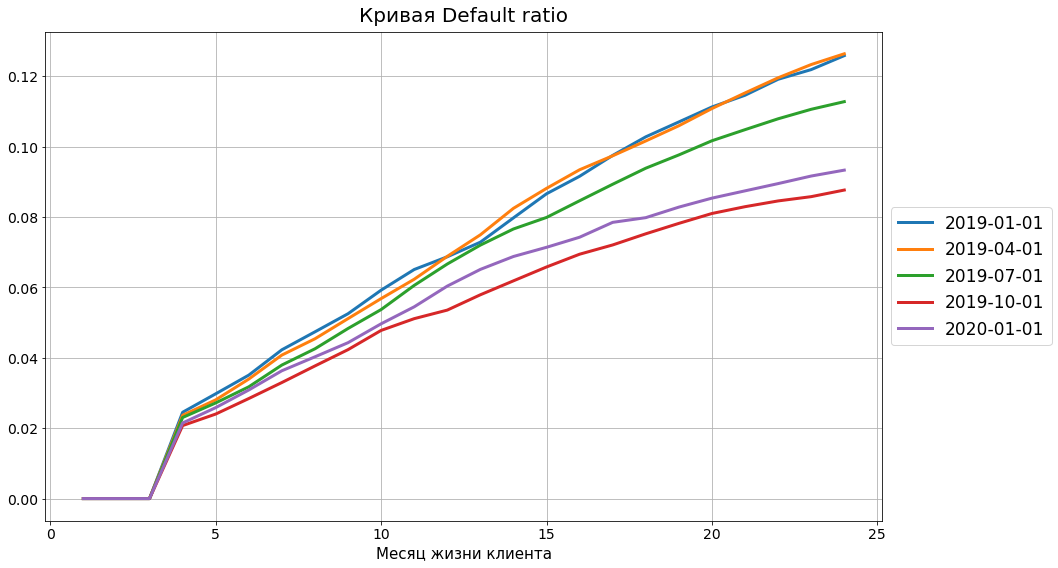

In [25]:
def plot_default_ratio_by_generation(df):
    return (df.groupby(["gen_quarter_dt", "statement_num"])
    .agg({"def_flg":np.mean})
    .rename(columns = {"def_flg": 'default_ratio'})
    .unstack('gen_quarter_dt')
    ['default_ratio']
    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))

plot_default_ratio_by_generation(df)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выберем переменную, которая делит кривые наилучшим образом

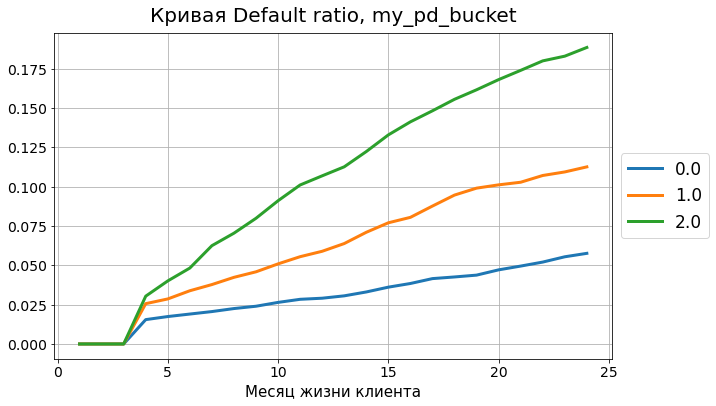

In [26]:
def plot_default_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_quarter_dt == '2019-01-01' ''')
    .groupby([bucket, "statement_num"])
    .agg({"def_flg":np.mean})
    .rename(columns = {"def_flg": 'default_ratio'})
    .unstack(bucket)
    ['default_ratio']
    .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_default_ratio_by_bucket(df, 'my_pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio, my_pd_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

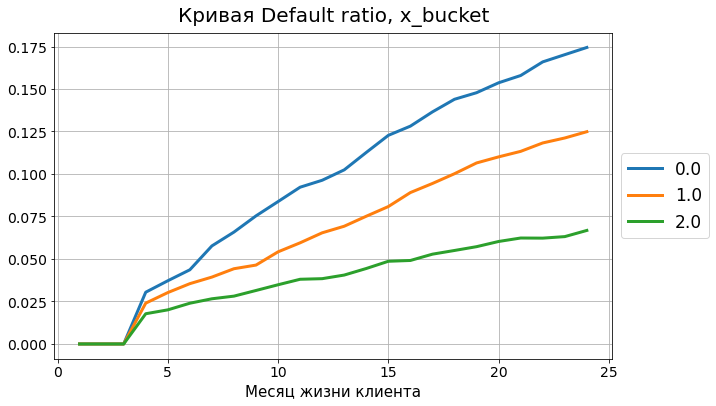

In [27]:
plot_default_ratio_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio, x_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Кривые лучше разделены по pd-бакетам => используем его

### Анализ странных поколений

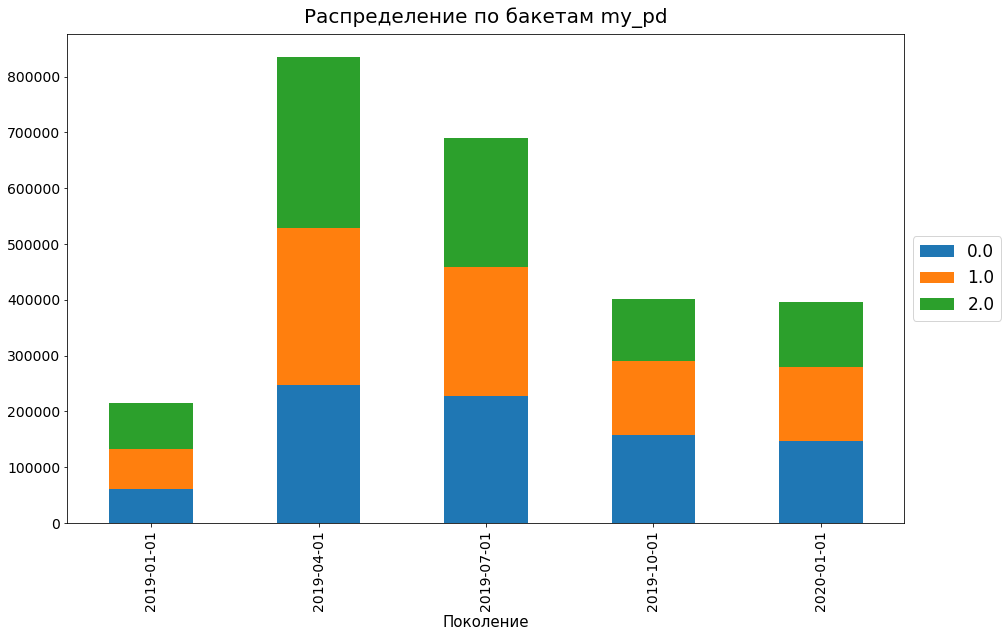

In [28]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_quarter_dt',
    values="user_id",
    aggfunc=np.count_nonzero, fill_value=0)\
   .T\
   .plot(kind='bar', stacked=True, figsize=(15, 9))    

plot_distribution(df, 'my_pd_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам my_pd", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

В январе 2019-года (начало первого квартал) данных мало, но достаточно для анализа, распределение по бакетам относительно равномерно, поэтому ничего не исключаем

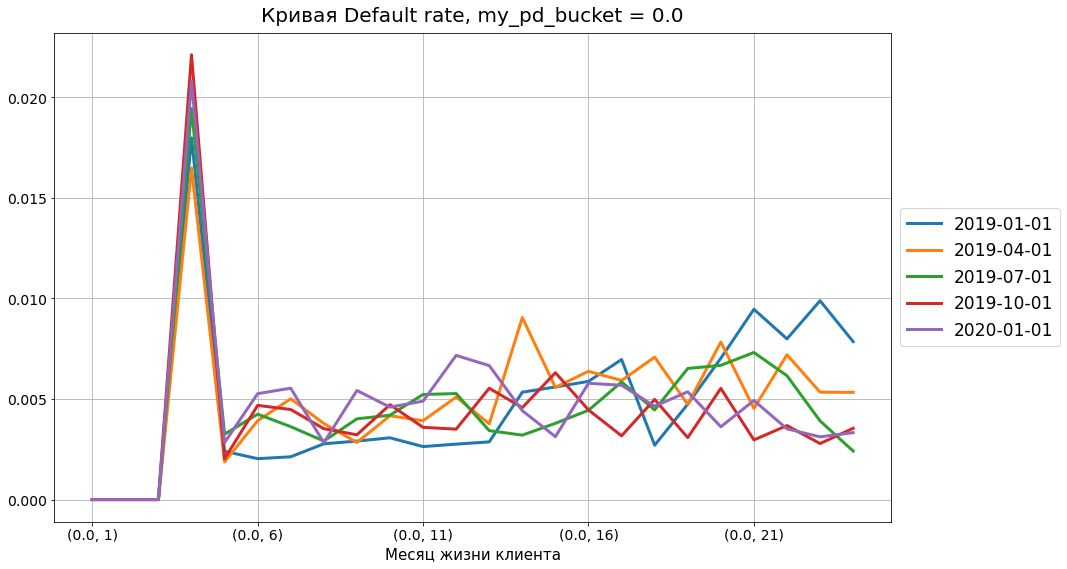

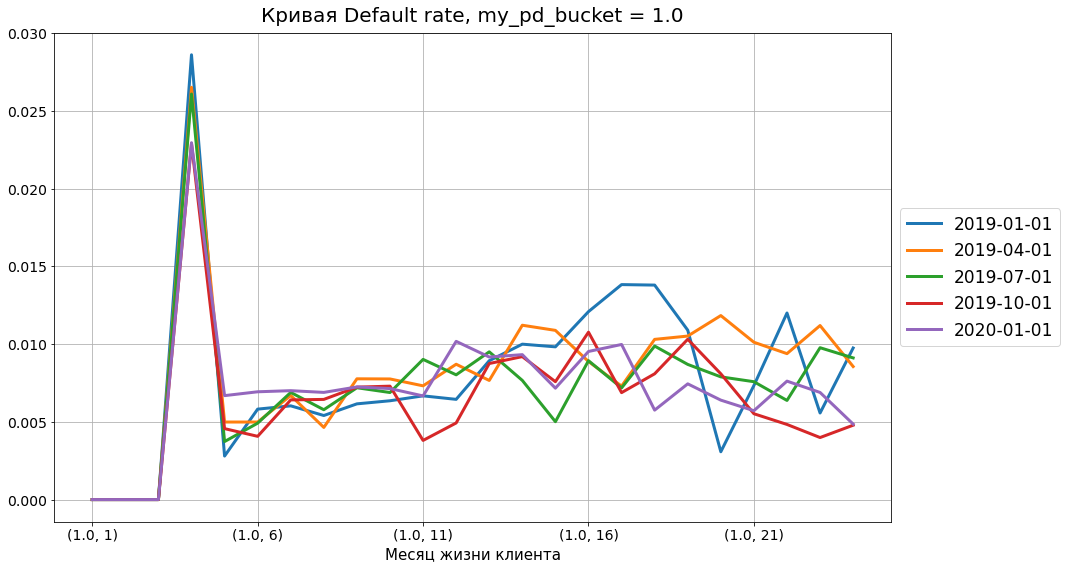

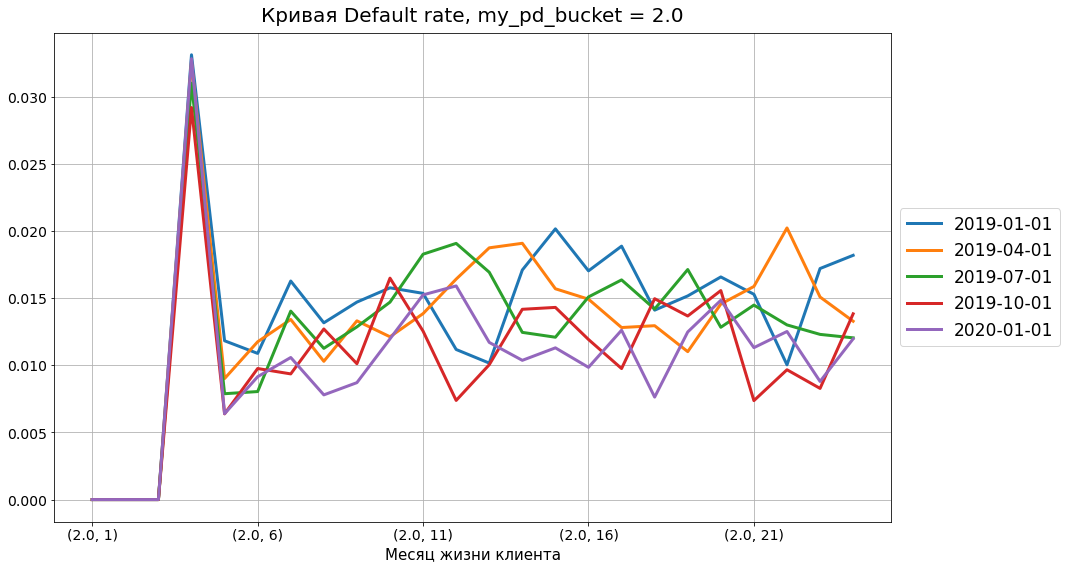

In [32]:
default_rate_data = df.eval('def_new_flg = def_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'my_pd_bucket', "statement_num"])\
    .agg({"def_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"def_new_flg":'def_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('default_rate = def_cnt / prev_act_cnt', inplace=False)

def plot_default_rate_by_generation(pd_bucket):
    cur_df = default_rate_data.query('my_pd_bucket == ' + str(pd_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['default_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Default rate, my_pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
buckets = df['my_pd_bucket'].drop_duplicates().sort_values(ascending = True)

for x_b in buckets:
    plot_default_rate_by_generation(x_b)

01-2019 крайне шумно по сравнению с остальными поколениями - имеется не похожее поведение по сравнению с остальными поколениями между 16 и 19 есть желание его удалить из бакета

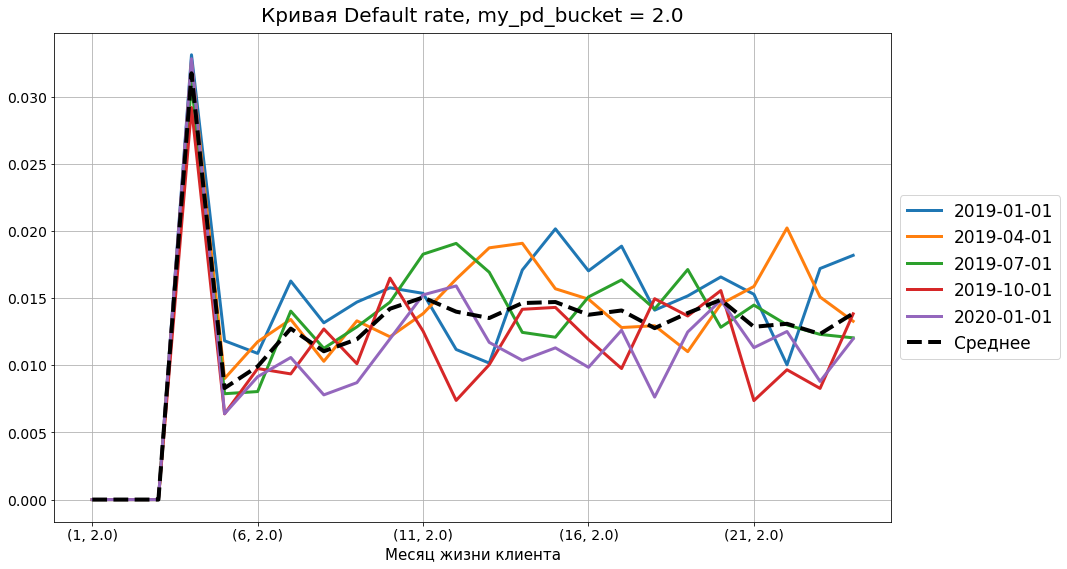

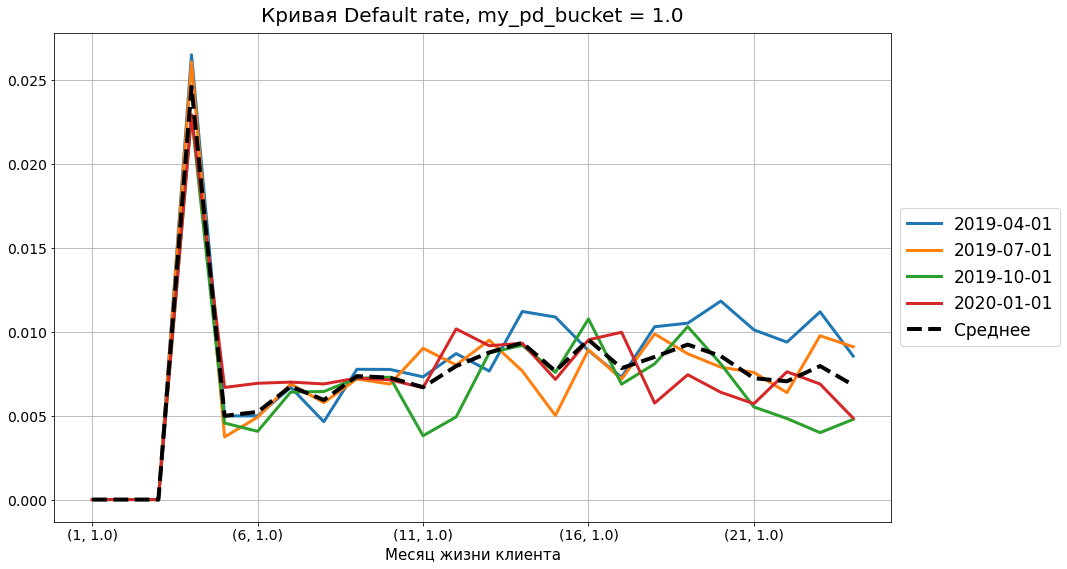

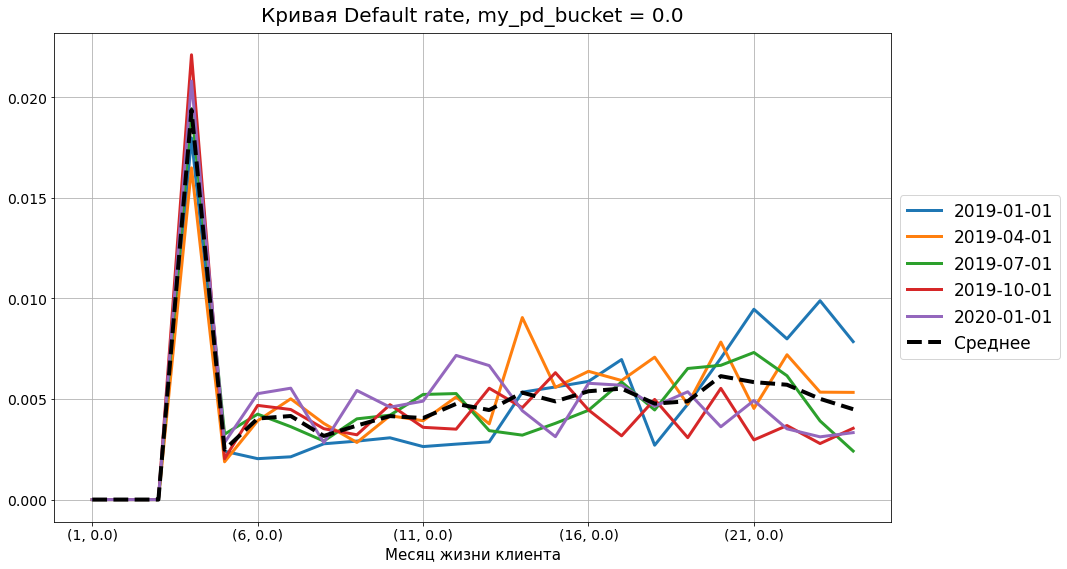

In [36]:
# Исключаем "странные" поколения

exception_query = ''' ~((gen_quarter_dt == '2019-01-01') & (my_pd_bucket == 1.0)) '''
default_rate_data.query(exception_query, inplace = True)

default_rate_mean = default_rate_data.groupby(['statement_num', 'my_pd_bucket'])\
    .agg({'default_rate':np.mean})\
    .rename(columns = {'default_rate':'Среднее'})

buckets = df['my_pd_bucket'].drop_duplicates()

def plot_default_rate_mean(pd_bucket):
    vintages_graph = default_rate_data.query('my_pd_bucket == ' + str(pd_bucket))\
            .unstack('gen_quarter_dt')\
            ['default_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (default_rate_mean.query('my_pd_bucket == ' + str(pd_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Default rate, my_pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    
for x_b in buckets:
    plot_default_rate_mean(x_b)

### Сглаживание средних кривых

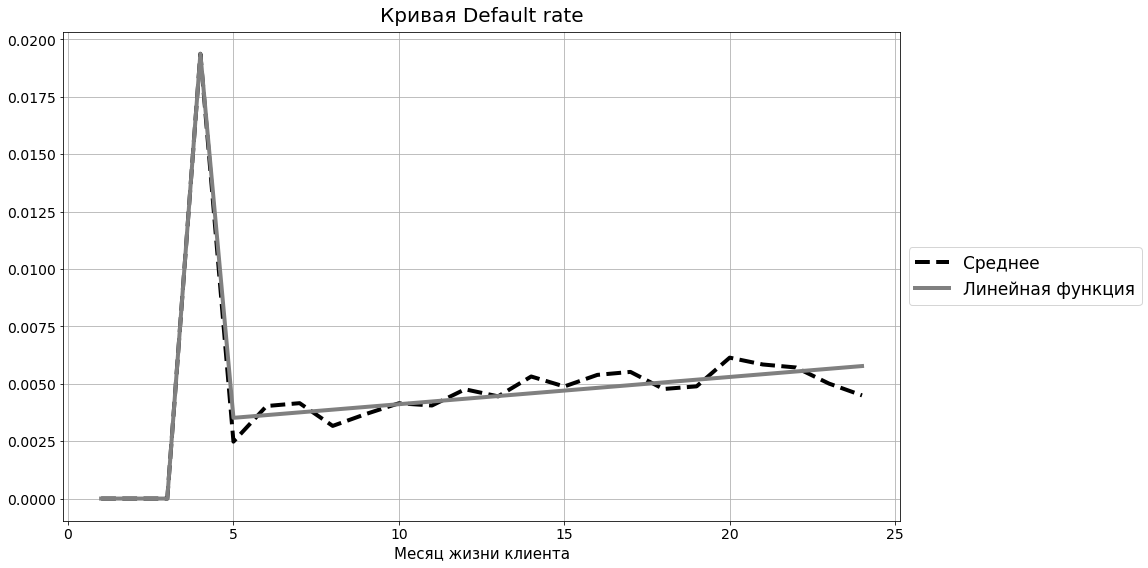

In [40]:
def approximation(df, start=1, finish=24):
#     код функции
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

df_linear = default_rate_mean.query('my_pd_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = approximation(df_linear, 5, 24)

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

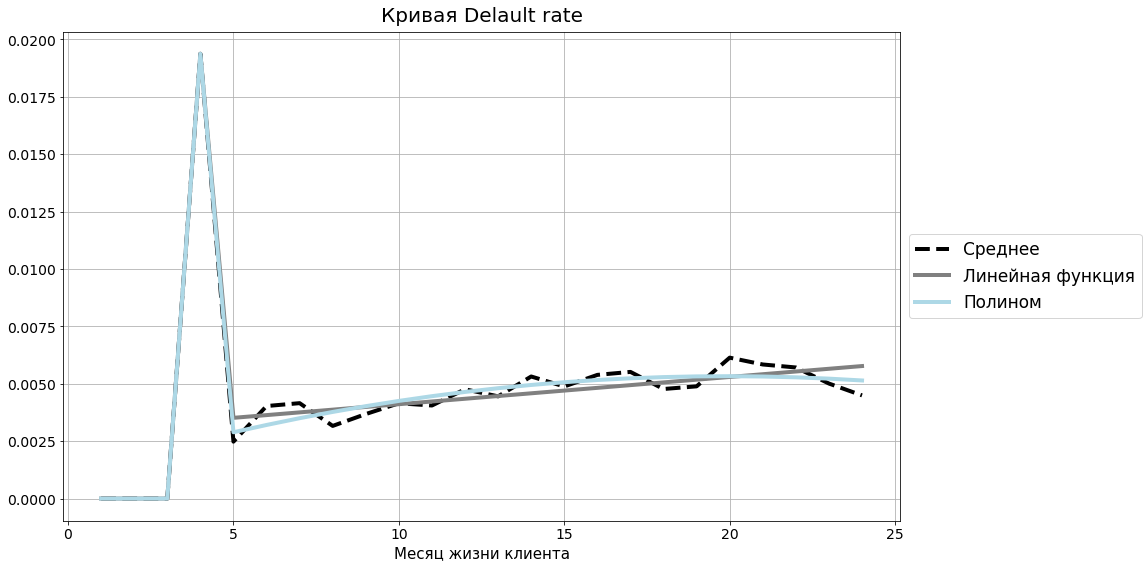

In [43]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 5,24,2)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Delault rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Выбран полином 2-го порядка - на графике видно, что он более-менее уловил все спуски и подъёмы в [5, 25]

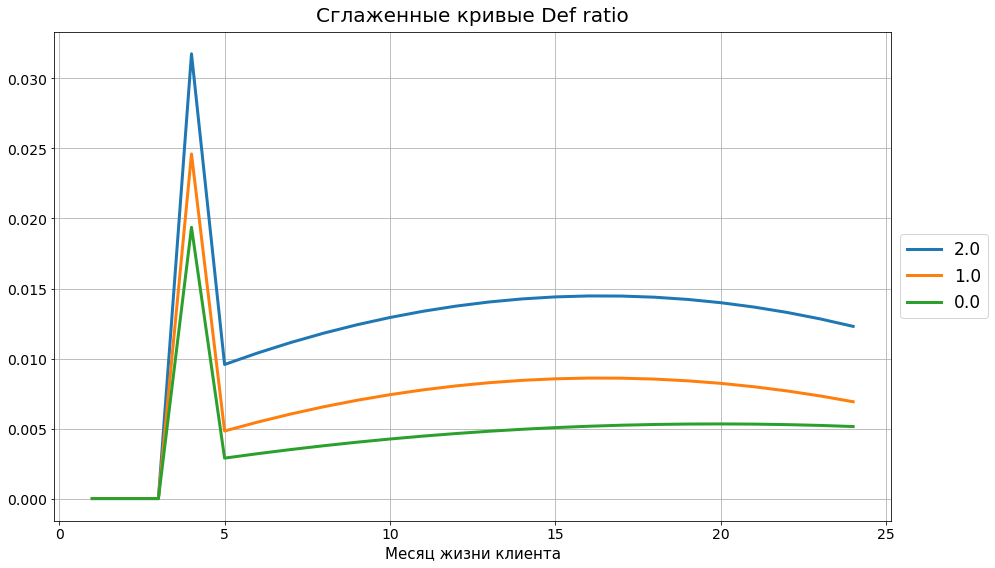

In [45]:
# код здесь
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['my_pd_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = default_rate_mean.query('my_pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5,24,2)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Def ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [99]:
df_smooth_result.to_csv('def_rate_by_buckets.csv')

## Кривые DLQ ratio

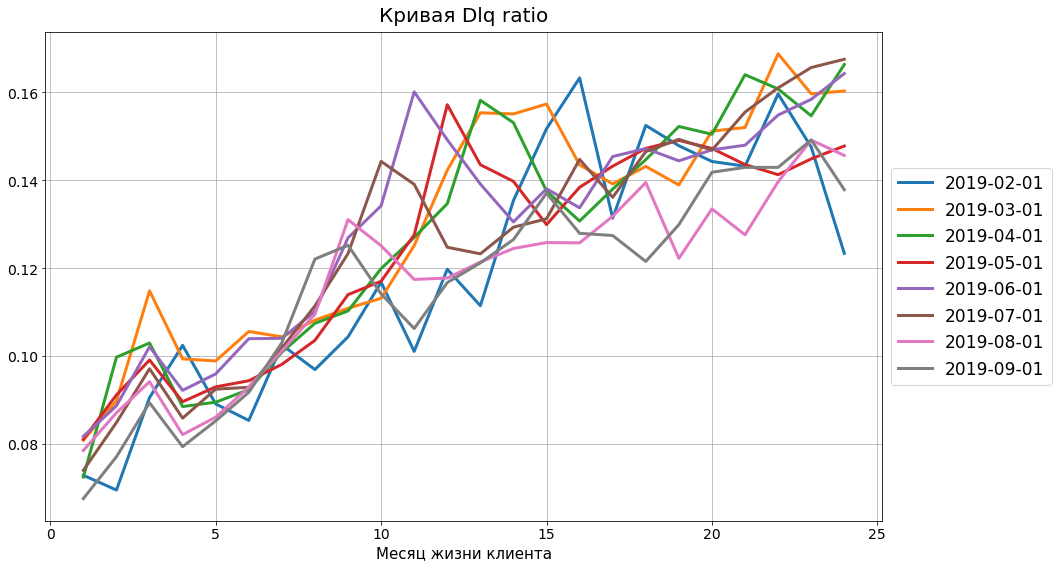

In [49]:
# DLQ ratio будем рассматривать по месяцам. Для удобства и наглядости возьмем только часть наблюдений
df = df[df['gen_month_dt'] < '2019-10-01']

def plot_dlq_ratio_by_generation(df):
    return (df.groupby(["gen_month_dt", "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack('gen_month_dt')
            ['dlq_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))               

# Строим график при помощи pyplot
plot_dlq_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выберем параметр для разделения кривых

#### Разделение по PD

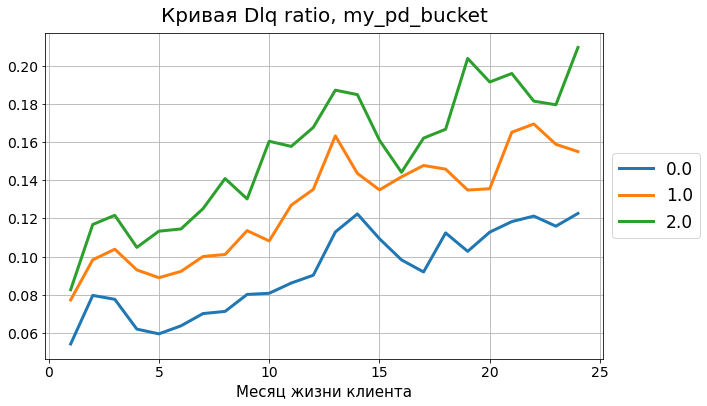

In [50]:
def plot_dlq_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_month_dt == '2019-04-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack(bucket)
            ['dlq_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_dlq_ratio_by_bucket(df, 'my_pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio, my_pd_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

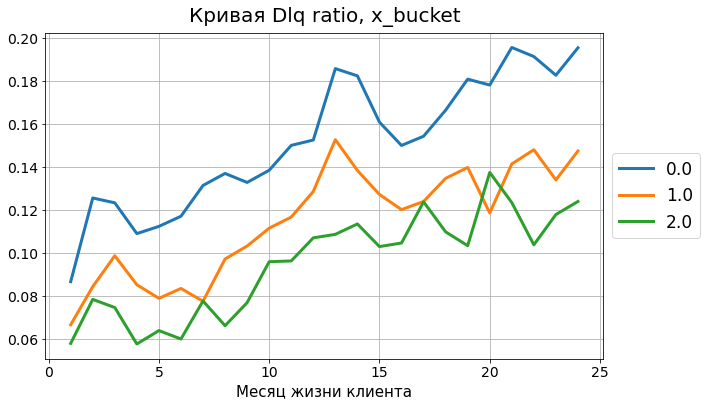

In [51]:
plot_dlq_ratio_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio, x_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

PD лучше разделяет кривые

### Странные поколения

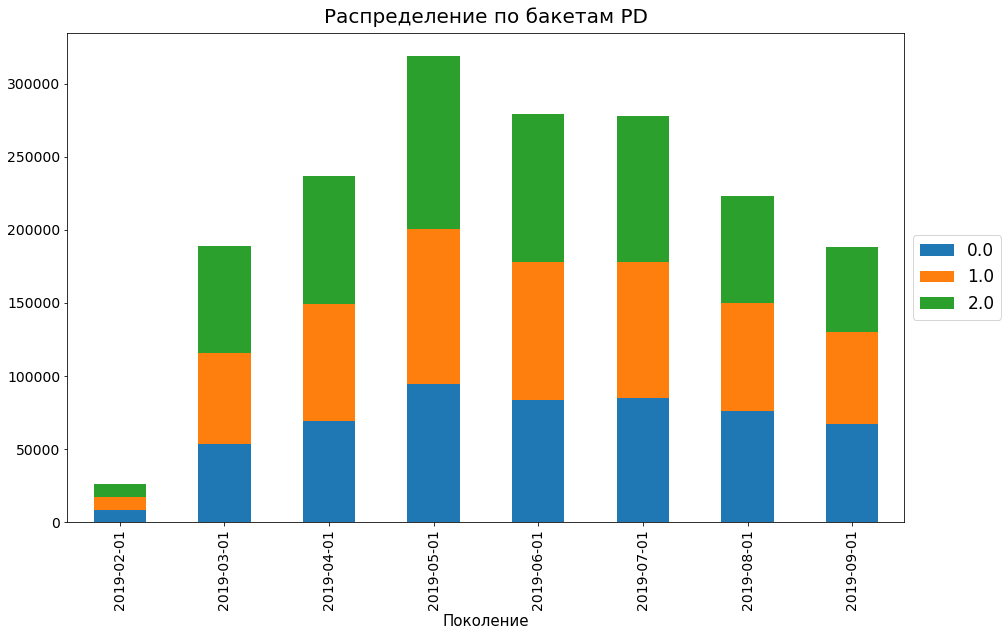

In [52]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))

plot_distribution(df, 'my_pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Во феврале 2019 года мало наблюдений, исключим это поколение из рассмотрения 

Разбивка по бакетам

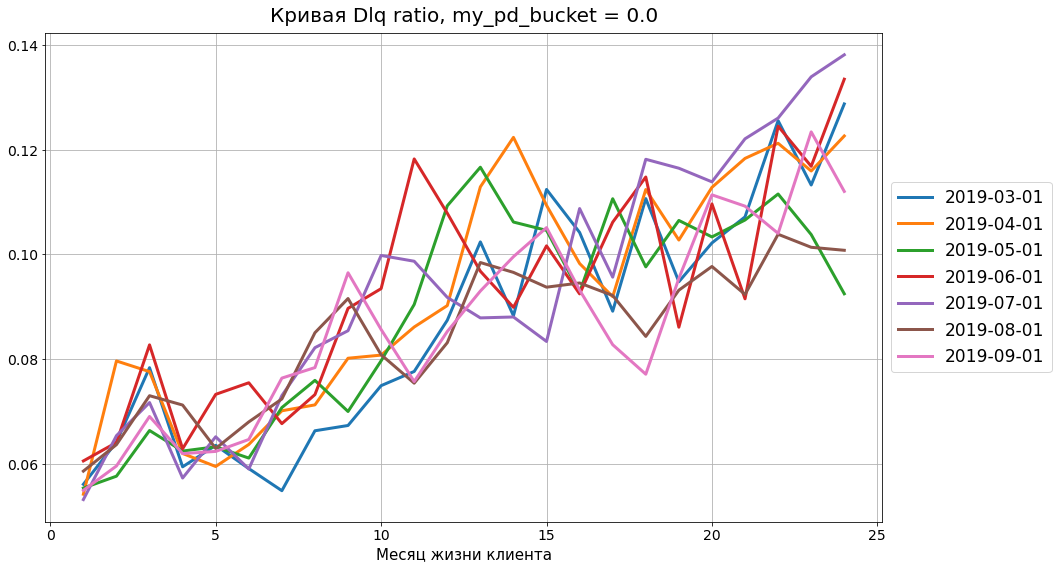

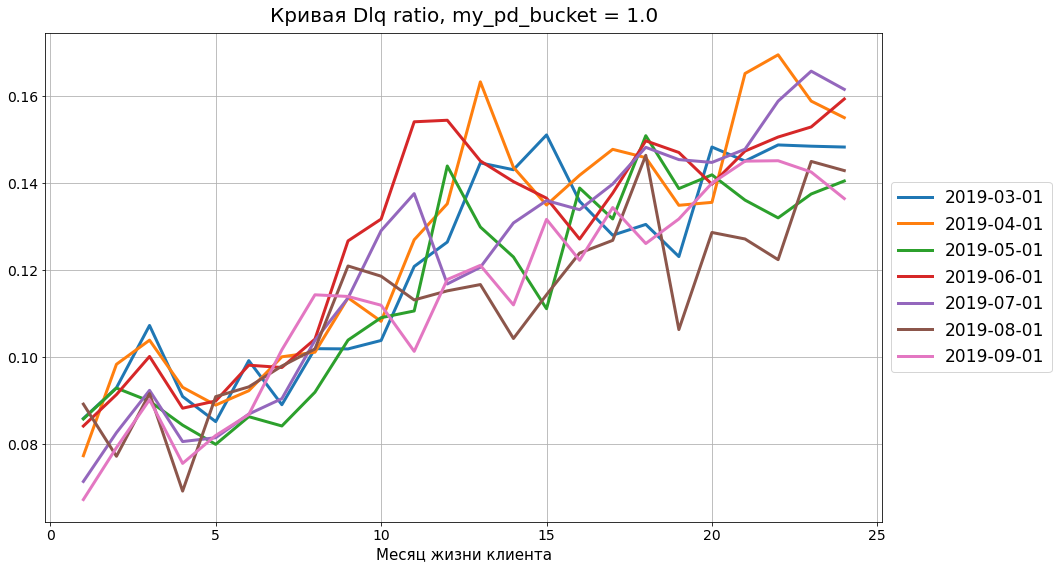

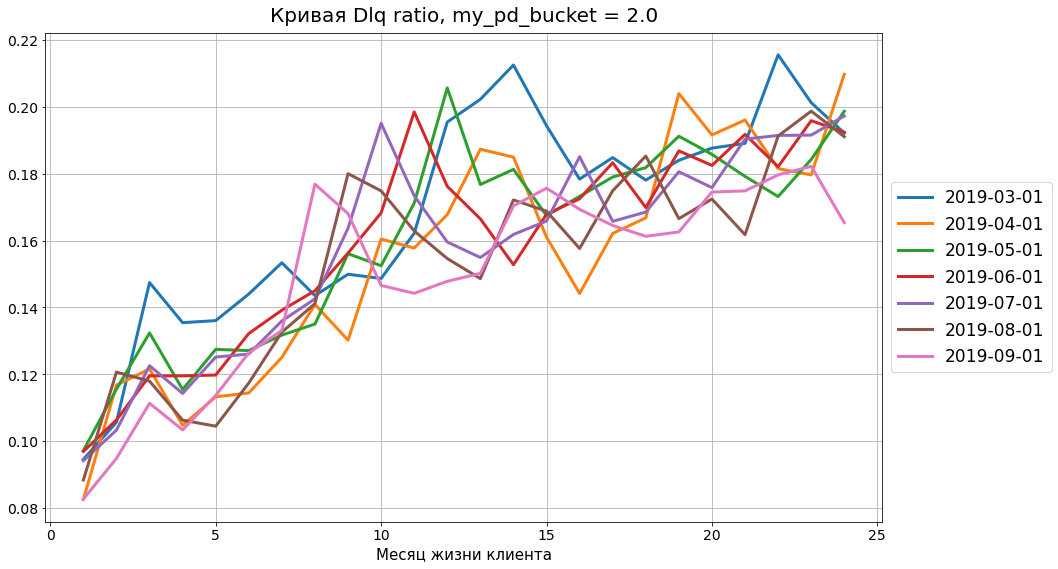

In [53]:
exception_query = ''' ~((gen_month_dt == '2019-02-01')) '''
df.query(exception_query, inplace = True)

def plot_dlq_ratio_by_generation(data, pd_bucket):
    data_tmp = data.query(''' my_pd_bucket == @pd_bucket''')\
        .groupby(["gen_month_dt", "statement_num"])\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
        .unstack('gen_month_dt')['dlq_ratio']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Dlq ratio, my_pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
buckets = [0.0, 1.0, 2.0]
for bucket in buckets:
    plot_dlq_ratio_by_generation(df, bucket)

#### Внешнее воздействие

In [54]:
def curve_build(data, 
                feature, 
                generation = 'generation_quart',
                statement_num = 'statement_num', 
                group_label = '1'):
    
    """Вспомогательная функция для построения разложения в рамках одного бакета
    
    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """
    
    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов 
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])
    
    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1 

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0 
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)], 
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице. 
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean
    
    # И умножаем на полученный коэффициент кривые созревания
    
    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df, 
                  generation = 'generation_month', 
                  group = 'bucket', 
                  statement_num = 'statement_num', 
                  feature = 'feature', 
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени
    
    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов
 
    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)
    
    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta
    
      # Формируем список бакетов
    
    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())
    
    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))
        
        # Строим разложение для одного бакета
        res = curve_build(df_temp, 
                          feature = feature, 
                          generation = generation, 
                          statement_num = statement_num, 
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp]) 
        i+=1
        
    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }    
    return res_multiple

In [59]:
# Подготавливаем данные
df_ratio = df.groupby(["my_pd_bucket","gen_month_dt", "statement_num"], as_index=False)\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)

df_ratio['gen_month_dt'] = pd.to_datetime(df_ratio['gen_month_dt'])

Nfeval = 0
res = decomposition(df_ratio, 
                       generation = 'gen_month_dt', 
                       group = 'my_pd_bucket', 
                       statement_num = 'statement_num', 
                       feature = 'dlq_ratio')

C:\Users\user\miniconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


my_pd_bucket = 0.0
Initial 1.409547
0  0.275687
1  0.271686
2  0.270988
3  0.270582
4  0.270321
5  0.269632
6  0.269482
7  0.265371
8  0.263754
9  0.255009
10  0.249912
11  0.224162
12  0.198118
13  0.165038
14  0.141702
15  0.068993
16  0.054153
17  0.035929
18  0.032186
19  0.029470
20  0.027393
21  0.025721
22  0.017494
23  0.016907
24  0.014643
25  0.014075
26  0.012051
27  0.011766
28  0.011445
29  0.011392
30  0.010820
31  0.010644
32  0.010225
33  0.010205
34  0.010196
35  0.010191
36  0.010186
37  0.010183
38  0.010174
39  0.010174
40  0.010172
41  0.010171
42  0.010163
43  0.010162
44  0.010158
45  0.010158
my_pd_bucket = 1.0
Initial 2.508415
46  0.445237
47  0.438611
48  0.437812
49  0.436387
50  0.436071
51  0.433633
52  0.432352
53  0.424316
54  0.420904
55  0.403292
56  0.384730
57  0.319979
58  0.307306
59  0.166824
60  0.139173
61  0.097109
62  0.079143
63  0.051746
64  0.046978
65  0.038409
66  0.037611
67  0.037003
68  0.036814
69  0.035894
70  0.035826
71  0.035711
72

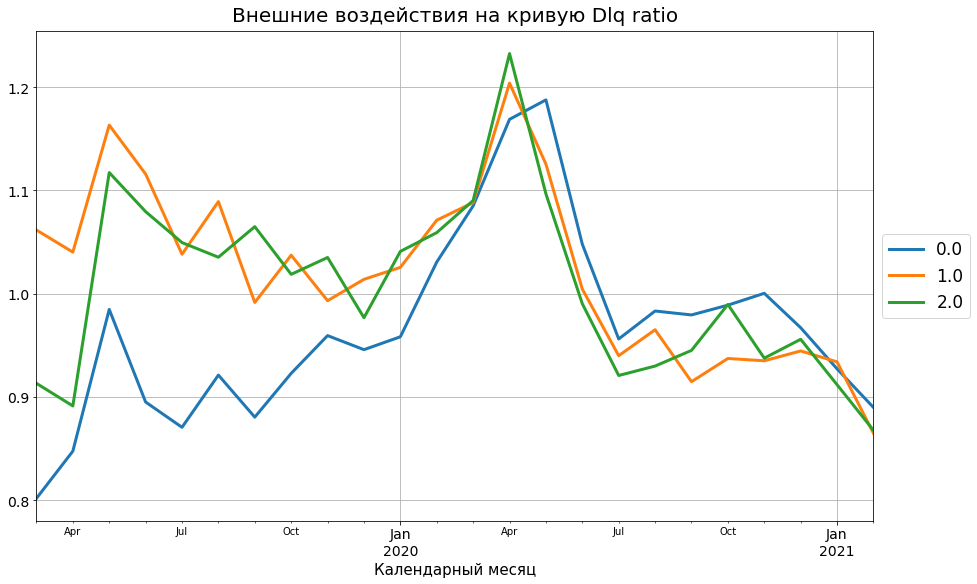

In [60]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

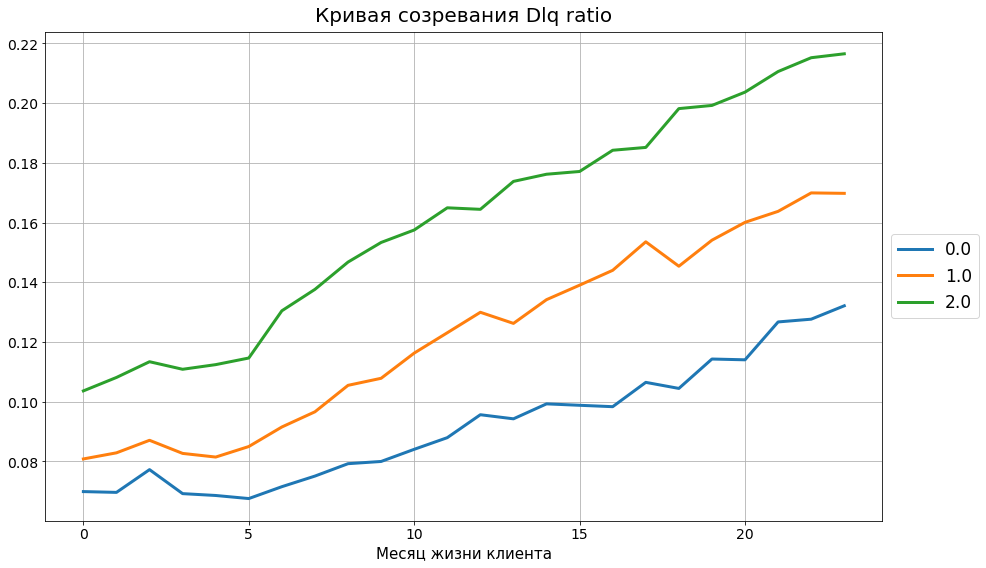

In [61]:
res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая созревания Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

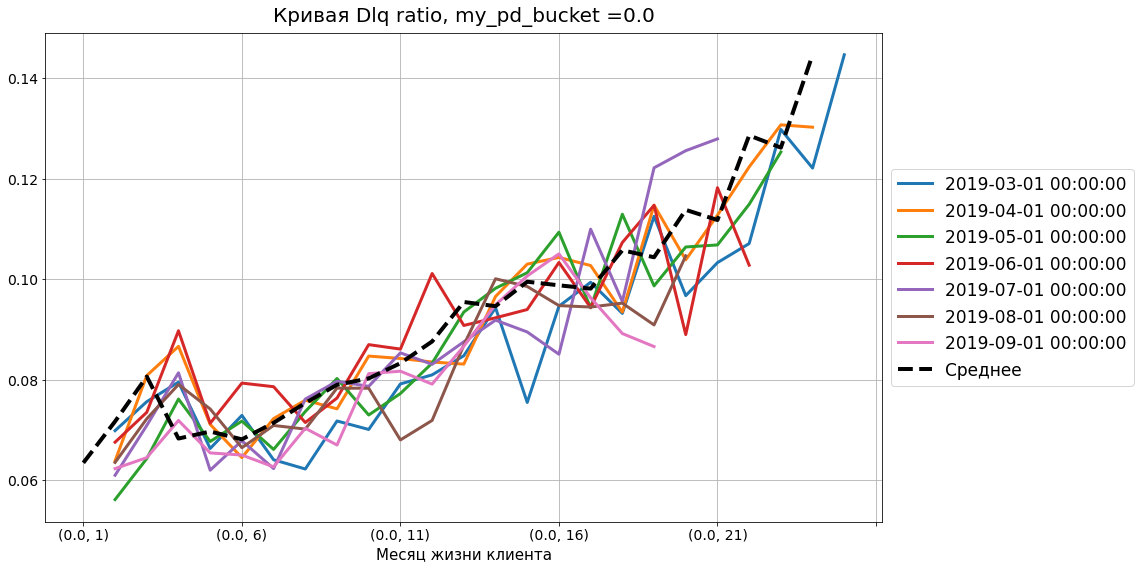

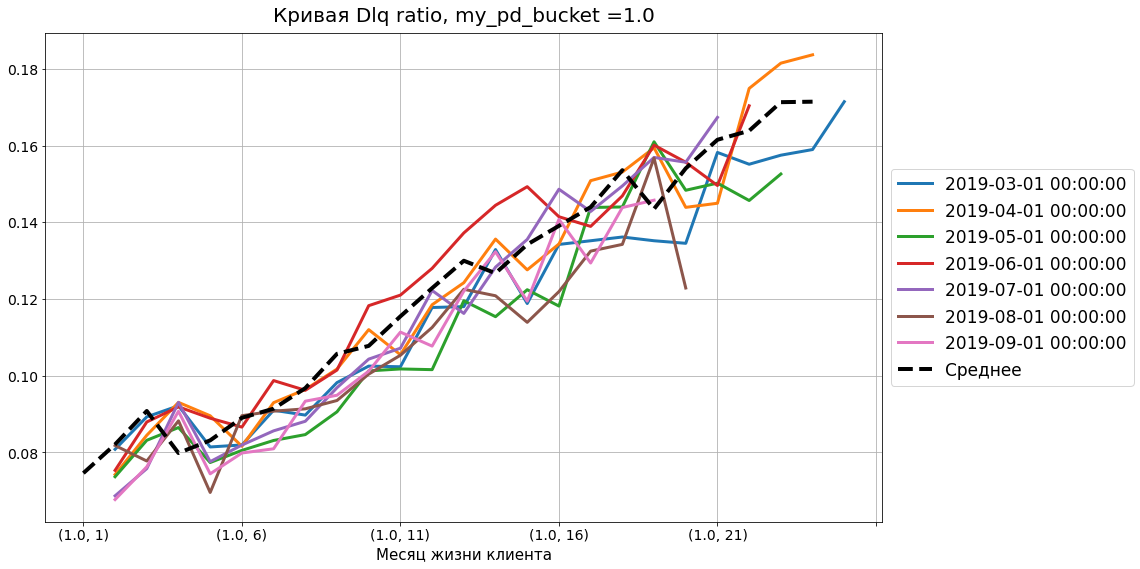

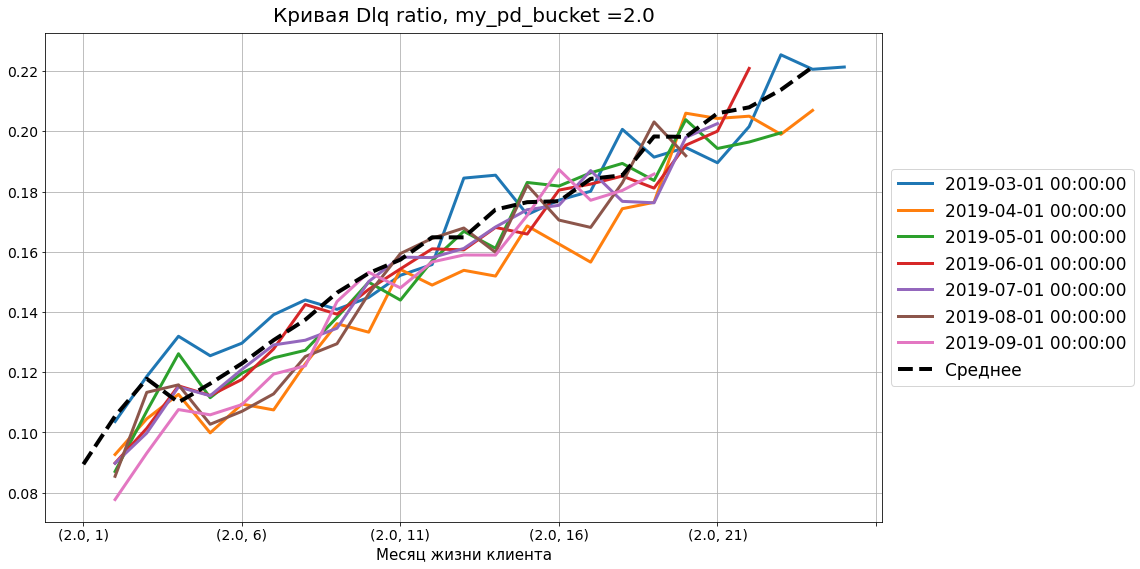

In [62]:
dlq_ratio_mean = res['fitted_data'].groupby([ 'my_pd_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

def plot_dlq_ratio_mean(pd_bucket):
    vintages_graph = res['fitted_data'].query('my_pd_bucket == ' + str(pd_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (dlq_ratio_mean.query('my_pd_bucket == ' + str(pd_bucket))['Среднее']
             .plot( figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Dlq ratio, my_pd_bucket =" + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for bucket in buckets:
    plot_dlq_ratio_mean(bucket)

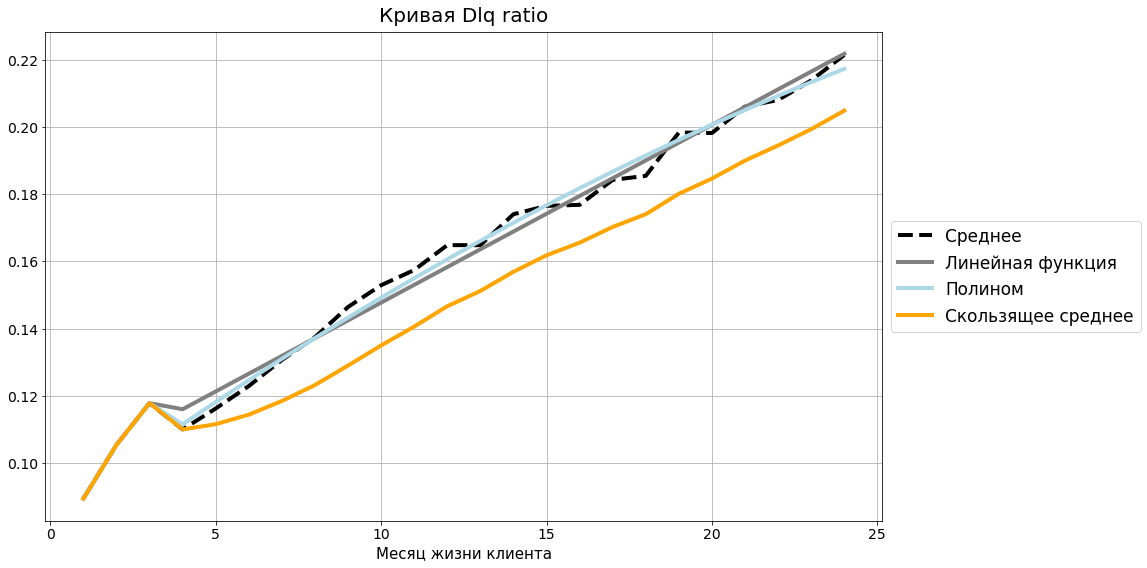

In [64]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

df_linear = dlq_ratio_mean.query('my_pd_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4,24,2)
df_smooth = exponential_smoothing(df_polynom, 4,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

В данном случае полином подходит лучше

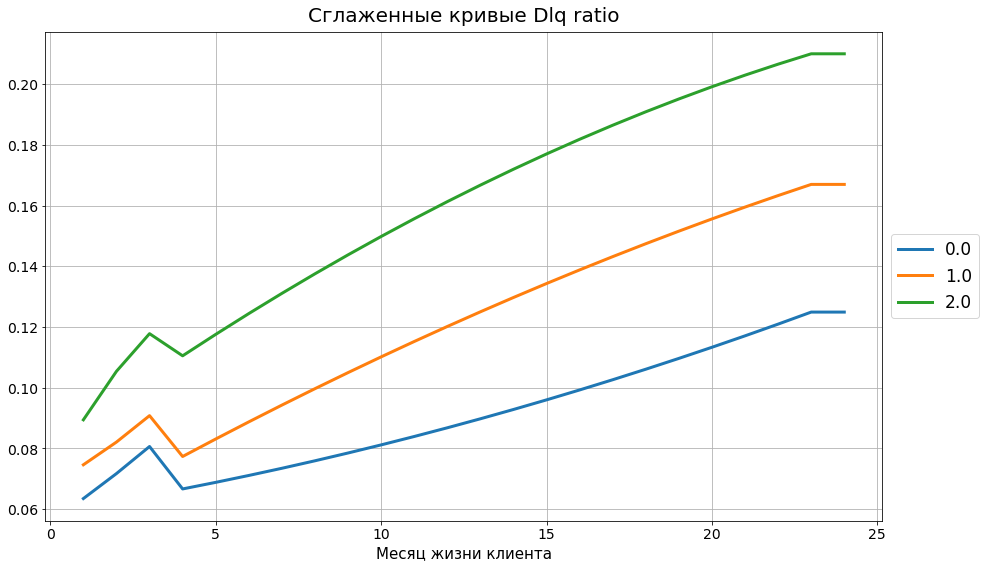

In [65]:
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = dlq_ratio_mean.query('my_pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4, 22, 2)['Полином']

# Строим итоговый график 
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [101]:
df_smooth_result.to_csv('dlq_ratio_by_buckets.csv')